In [ ]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

# read_data

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [ ]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

In [ ]:
# 발전량이 0인 시간대 (7시 이전, 17시 이후) 데이터는 제외
# pv['time'] = [i.time() for i in pv['datetime']]
# pv = pv[(pv['time']>=time(7, 0, 0)) & (pv['time']<time(17,0,0))]

In [ ]:
pv.head()

,time,power,datetime,month,day,alt,azi,rad,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,01/01/06 00,0.0,2006-01-01 00:00:00-06:00,1,1,-82.519778,6.327078,0.0,17.6,15.9,90.0,NaN,NaN,130.0,5.4,NaN,1013.9,NaN,NaN
1,01/01/06 01,0.0,2006-01-01 01:00:00-06:00,1,1,-74.001270,66.094544,0.0,15.1,14.5,96.0,0.0,NaN,180.0,11.2,NaN,1014.7,NaN,NaN
2,01/01/06 02,0.0,2006-01-01 02:00:00-06:00,1,1,-61.530551,82.353403,0.0,15.1,14.5,96.0,0.0,NaN,200.0,11.2,NaN,1015.0,NaN,NaN
3,01/01/06 03,0.0,2006-01-01 03:00:00-06:00,1,1,-48.633108,91.048671,0.0,15.7,15.1,96.0,0.0,NaN,180.0,11.2,NaN,1014.9,NaN,NaN
4,01/01/06 04,0.0,2006-01-01 04:00:00-06:00,1,1,-35.752419,97.771663,0.0,15.7,15.1,96.0,0.0,NaN,170.0,9.4,NaN,1014.7,NaN,NaN


# decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(pv['power'], freq=24)

<Figure size 432x288 with 0 Axes>

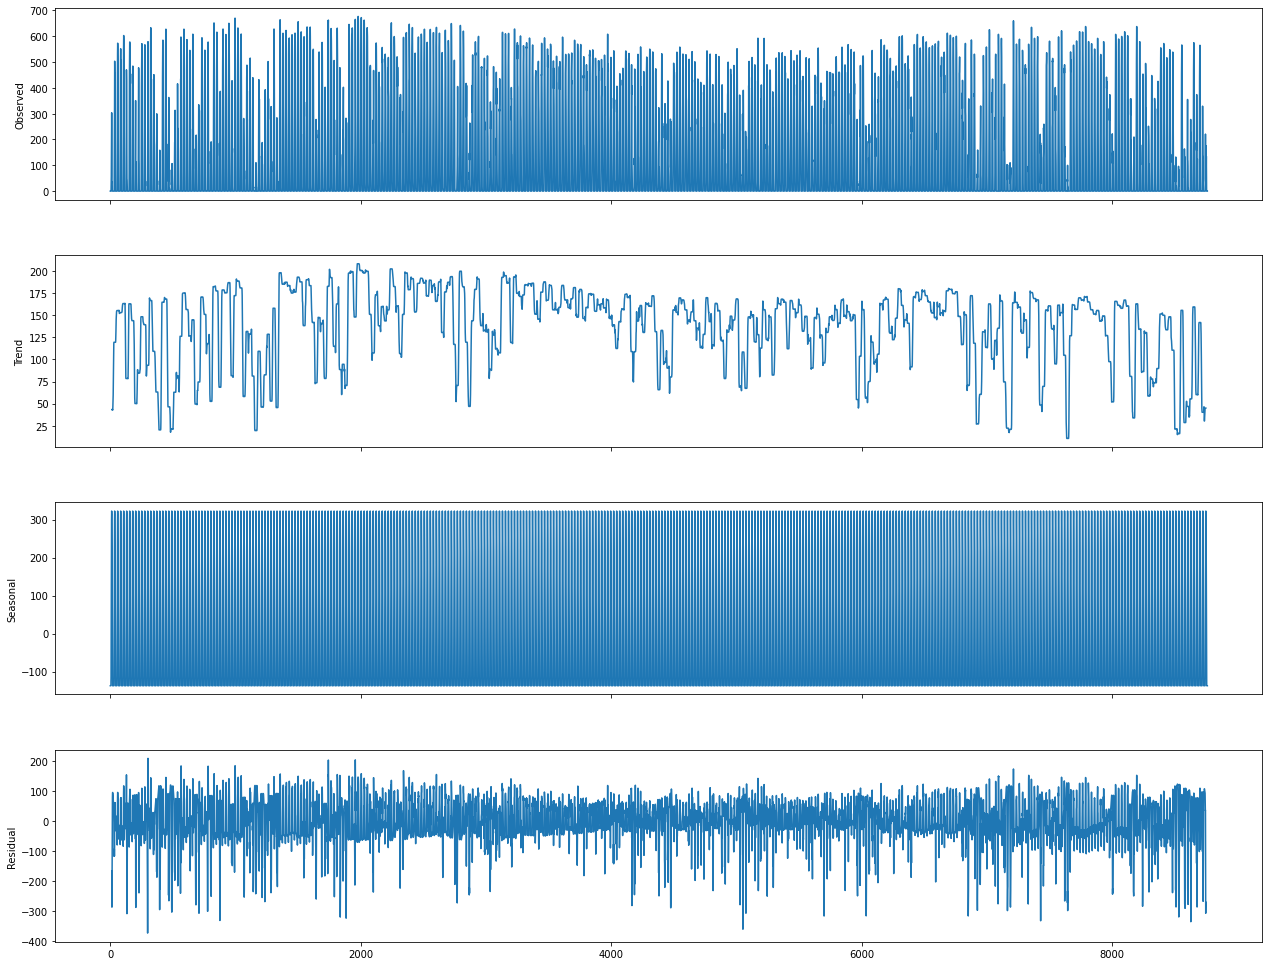

In [ ]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

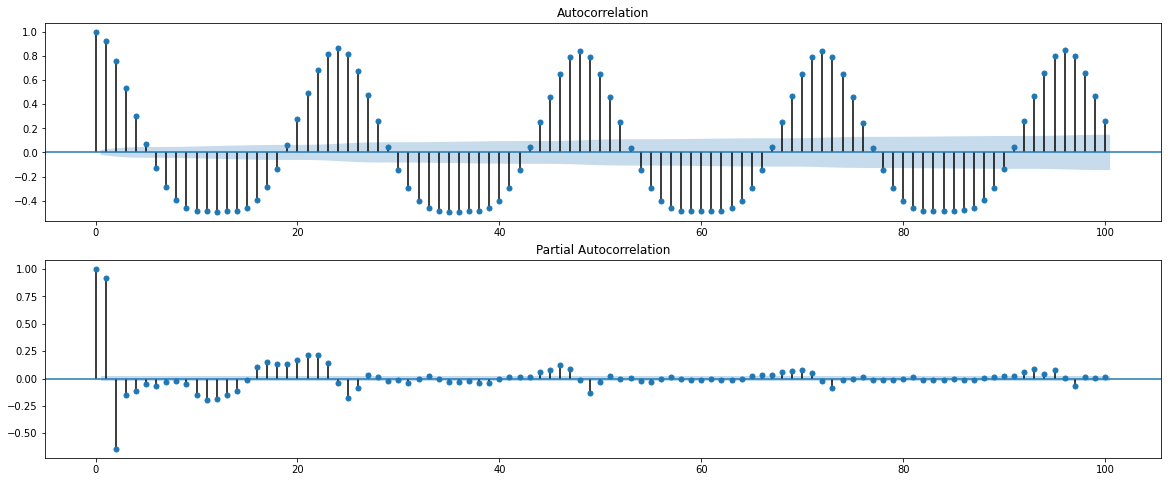

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pv['power'], lags=100, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pv['power'], lags=100, ax=ax2)

# 24 주기로 seasonality

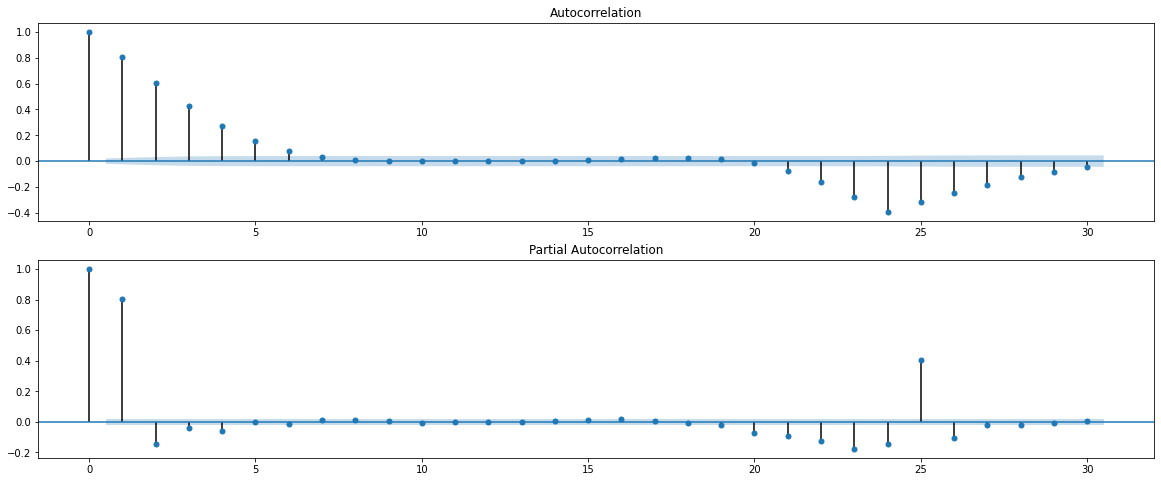

In [ ]:
pv['power_diff'] = pv['power'].diff(24)
pv_temp = pv['power_diff'].dropna()

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pv_temp, lags=30, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pv_temp, lags=30, ax=ax2)

# SARIMA & SARIMAX

p : pacf에서 수렴하기 직전값

d : adf테스트 및 추세의 가시적 확인으로 추세여부 확인

q : acf에서 수렴하기 직전값

P : pacf에서 계절성이 주기가 몇 번 반복 됐는지 확인 

D : 계절성이 있는지 확인하고 계절성 차분의 필요성에 따라 1 or 0 

Q : acf기준 계절성 주기가 몇 번 반복 됐는지 확인

m : 계절성 주기 



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
tz = timezone(timedelta(hours=-6))
start = datetime(2006,12,31,00,tzinfo=tz)
end = datetime(2006,12,31,23,00,tzinfo=tz)

# SARIMA

In [ ]:
pv = pv.set_index('datetime')

In [ ]:
pv_train = pv.loc[:datetime(2006,12,30,23,tzinfo=tz)]
pv_test = pv.loc[start:]

In [ ]:
# 시각적으로 파악한 parameter -> 공부 필요
trend_order = (2,0,0)
seasonal_order = (1,0,0,24)

result = SARIMAX(endog=pv_train['power'], exog=None, order=trend_order, seasonal_order=seasonal_order).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
result.summary()
# -> 잔차 가정 만족 x, 처리 필요
# index 끊기면 sample 에 date type 으로 안 나옴

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              power   No. Observations:                 8736
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -47143.488
Date:                            Tue, 12 Apr 2022   AIC                          94294.975
Time:                                    06:06:21   BIC                          94323.276
Sample:                                01-01-2006   HQIC                         94304.620
                                     - 12-30-2006                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1060      0.006    182.251      0.000       1.094       1.118
ar.L2         -0.2473      0.006    -40.368      0.000      -0.259      -0.235
ar.S.L24       0.6271      0.006    111.197      0.000       0.616       0.638
sigma2      2845.4290     21.948    129.645      0.000    2802.412    2888.446
===================================================================================
Ljung-Box (Q):                     1805.48   Jarque-Bera (JB):             18115.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

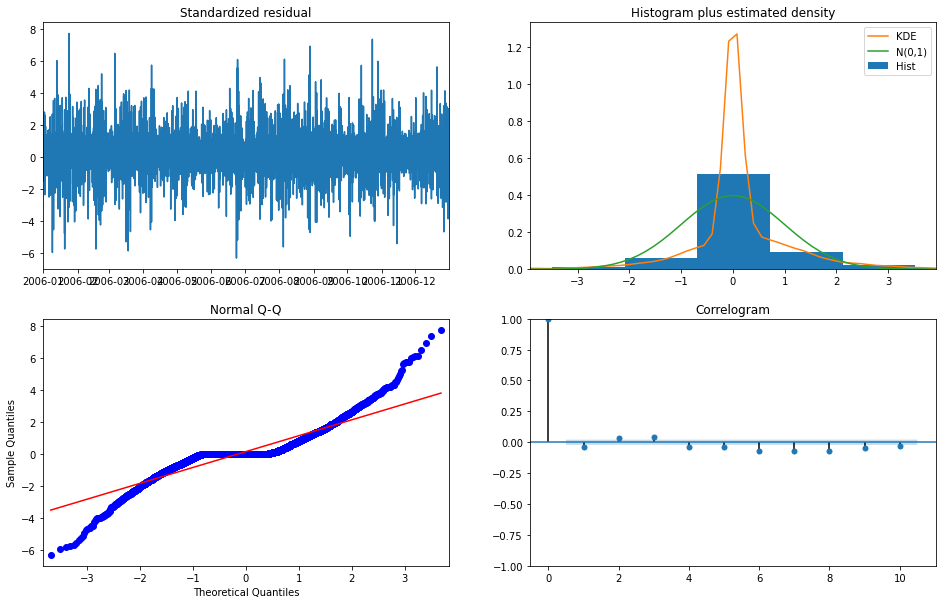

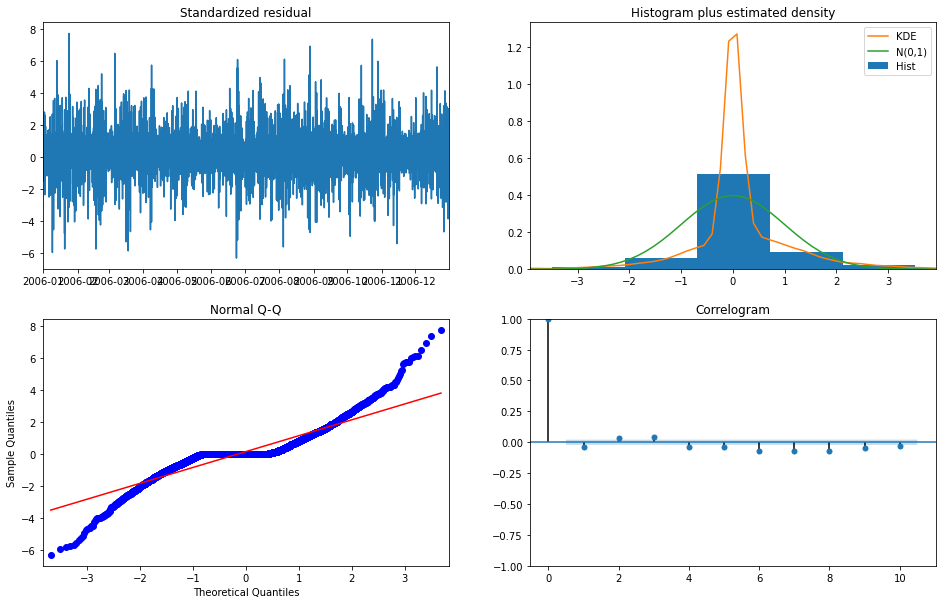

In [ ]:
result.plot_diagnostics(figsize=(16,10))

In [ ]:
pred = result.get_prediction(start=start, end=end, exog=None, dynamic=False)
pv_test['pred_mean'] = pred.predicted_mean.values
pv_test[['lb', 'ub']] = pred.conf_int()[['lower power', 'upper power']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


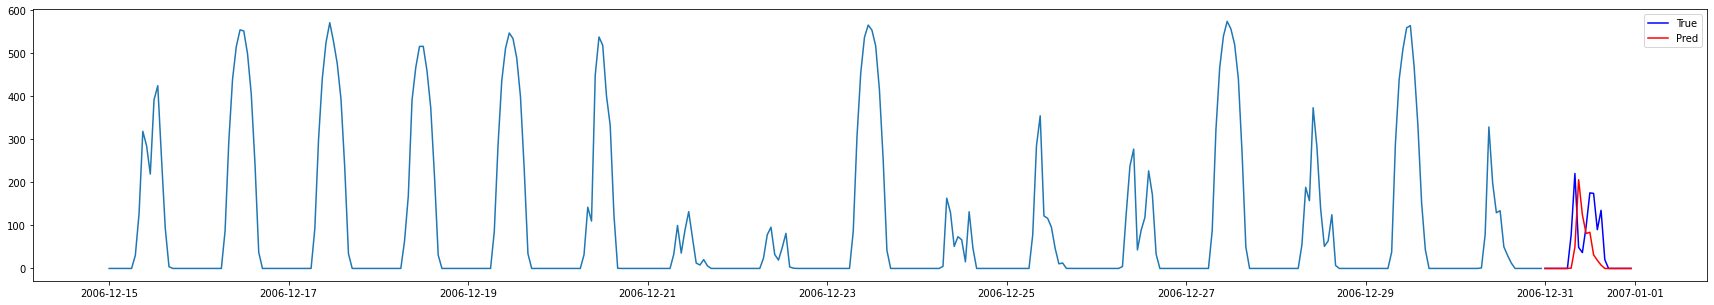

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 5)

# ax.fill_between(pv_test.index, pv_test['ub'], pv_test['lb'], facecolor='red', interpolate=True, alpha = 0.2)
ax.plot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):, 'power'])
ax.plot(pv_test.index, pv_test['power'], 'b', label='True')
ax.plot(pv_test.index, pv_test['pred_mean'], 'r', label='Pred')
plt.legend()

## SARIMAX

In [ ]:
# 시각적으로 파악한 parameter -> 공부 필요
trend_order = (2,0,0)
seasonal_order = (1,0,0,24)

result = SARIMAX(endog=pv_train['power'], exog=pv_train[['dwpt', 'rhum', 'wspd', 'pres']], order=trend_order, seasonal_order=seasonal_order).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
result.summary()
# -> 잔차 가정 만족 x, 처리 필요

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              power   No. Observations:                 8736
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -47002.583
Date:                            Tue, 12 Apr 2022   AIC                          94021.167
Time:                                    06:09:04   BIC                          94077.768
Sample:                                01-01-2006   HQIC                         94040.455
                                     - 12-30-2006                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dwpt          -3.2612      0.465     -7.007      0.000      -4.173      -2.349
rhum           0.8889      0.123      7.244      0.000       0.648       1.129
wspd           0.0542      0.106      0.513      0.608      -0.153       0.261
pres           0.1173      0.013      9.108      0.000       0.092       0.143
ar.L1          1.1046      0.007    167.859      0.000       1.092       1.118
ar.L2         -0.2784      0.006    -43.869      0.000      -0.291      -0.266
ar.S.L24       0.5876      0.006     91.818      0.000       0.575       0.600
sigma2      2755.4318     24.791    111.145      0.000    2706.842    2804.022
===================================================================================
Ljung-Box (Q):                     1945.51   Jarque-Bera (JB):             16216.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

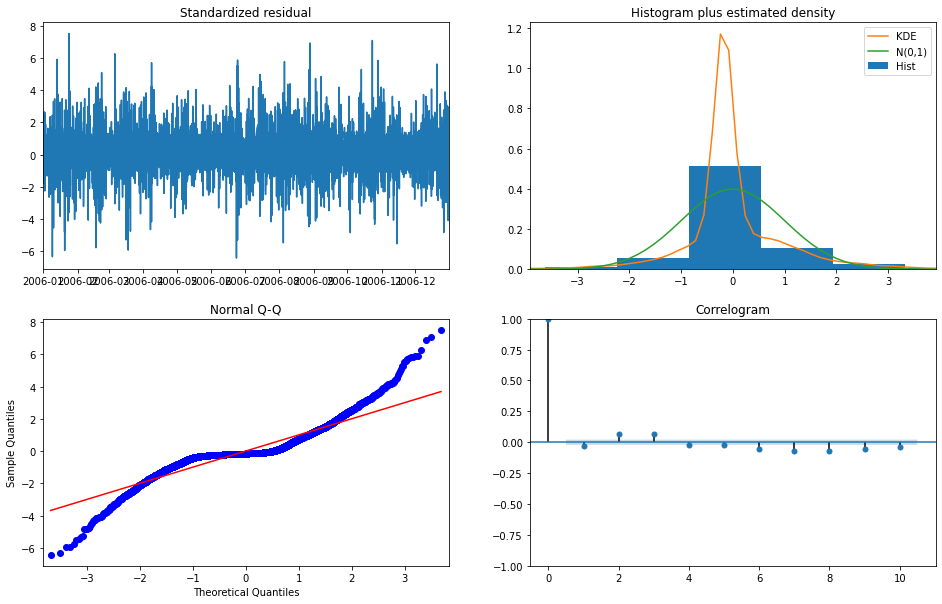

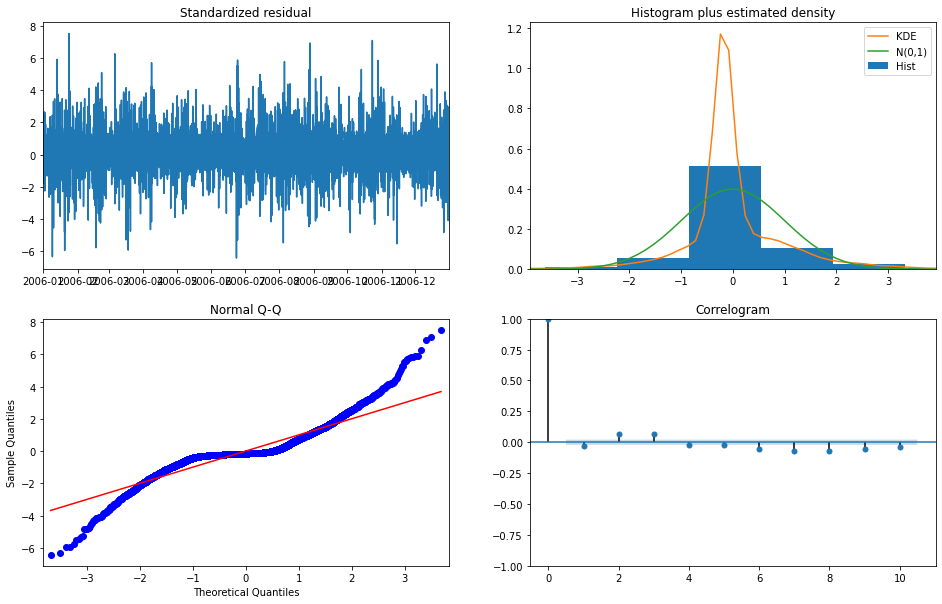

In [ ]:
result.plot_diagnostics(figsize=(16,10))

In [ ]:
pred = result.get_prediction(start=start, end=end, exog=pv_test[['dwpt', 'rhum', 'wspd', 'pres']], dynamic=False)
pv_test['pred_mean'] = pred.predicted_mean.values
pv_test[['lb', 'ub']] = pred.conf_int()[['lower power', 'upper power']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


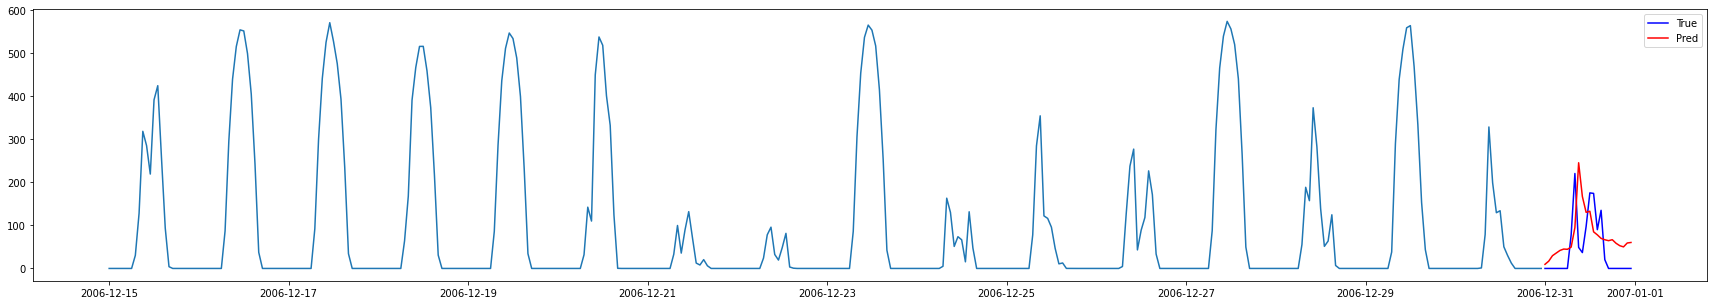

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 5)

# ax.fill_between(pv_test.index, pv_test['ub'], pv_test['lb'], facecolor='red', interpolate=True, alpha = 0.2)
ax.plot(pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,15,00,tzinfo=tz):, 'power'])
ax.plot(pv_test.index, pv_test['power'], 'b', label='True')
ax.plot(pv_test.index, pv_test['pred_mean'], 'r', label='Pred')
plt.legend()